In [5]:
# Useful starting lines
%matplotlib inline

import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from test_utils import test
import time


%load_ext autoreload
%autoreload 2

# Support Vector Machines
## Classification Using SVM
Load dataset. We will use a toy dataset from sklearn.

In [6]:
from sklearn import datasets

# Load dataset
sklearn_dataset = datasets.load_breast_cancer()
Xx = sklearn_dataset.data
y = sklearn_dataset.target * 2 - 1  # labels must be in {-1, 1} for the hinge loss
X = np.ones((Xx.shape[0], Xx.shape[1] + 1))
X[:, :-1] = Xx
print("(N, D) =", X.shape)

(N, D) = (569, 31)


## Prepare cost and prediction functions

In [7]:
def calculate_primal_objective(y, X, w, lambda_):
    """compute the full cost (the primal objective, equation (1) in the exercise pdf),
        that is loss plus regularizer.

    Args:
        X: the full dataset matrix, shape = (num_examples, num_features)
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        w: shape = (num_features)

    Returns:
        scalar, non-negative

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1, 2, 3], [4, 5, 6]])
    >>> w_test = np.array([0, 1, 5])
    >>> calculate_primal_objective(y_test, x_test, w_test, 1)
    31.0
    """
    ### SOLUTION
    hinge_loss = np.clip(1 - y * (X @ w), 0, np.inf)
    return np.mean(hinge_loss) + lambda_ / 2 * np.sum(w**2)
    ### END SOLUTION

In [8]:
test(calculate_primal_objective)

✅ Your `calculate_primal_objective` passed 4 tests.


In [9]:
def calculate_accuracy(y, X, w):
    """compute the accuracy on the given dataset (X, y) using the model w.

    Args:
        X: the full dataset matrix, shape = (num_examples, num_features)
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        w: shape = (num_features)

    Returns:
        scalar, between 0 and 1

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1, 2, 3], [4, 5, 6]])
    >>> w_test = np.array([0, 1, 5])
    >>> calculate_accuracy(y_test, x_test, w_test)
    0.5
    """
    ### SOLUTION
    predicted_y = (X @ w > 0) * 2 - 1
    accuracy = np.mean(predicted_y == y)
    return accuracy
    ### END SOLUTION

In [10]:
test(calculate_accuracy)

✅ Your `calculate_accuracy` passed 4 tests.


## Stochastic Gradient Descent for SVM

Compute the (stochastic) subgradient for the n-th summand of the SVM optimization objective

In [11]:
def calculate_stochastic_gradient(y, X, w, lambda_, n, num_examples):
    """compute the stochastic gradient of loss plus regularizer.

    Args:
        X: the dataset matrix, shape = (num_examples, num_features)
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        w: shape = (num_features)
        lambda_: positive scalar number
        n: the index of the (one) datapoint we have sampled
        num_examples: N

    Returns:
        numpy array, shape = (num_features)

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1, 2, 3], [4, 5, 6]])
    >>> w_test = np.array([0, 1, 5])
    >>> calculate_stochastic_gradient(y_test, x_test, w_test, 1, 1, 2)
    array([ 4,  6, 11])
    """

    ### SOLUTION
    def is_support(y_n, x_n, w):
        """a datapoint is support if max{} is not 0."""
        return y_n * x_n @ w < 1

    x_n, y_n = X[n], y[n]
    grad = -y_n * x_n if is_support(y_n, x_n, w) else np.zeros_like(x_n)
    grad = grad + lambda_ * w
    return grad
    ### END SOLUTION

In [12]:
test(calculate_stochastic_gradient)

✅ Your `calculate_stochastic_gradient` passed 4 tests.


Implement stochastic gradient descent: Pick a data point uniformly at random and update w based on the gradient for the n-th summand of the objective

Final training accuracy = 90.86 %
Training time: 2.1 seconds 


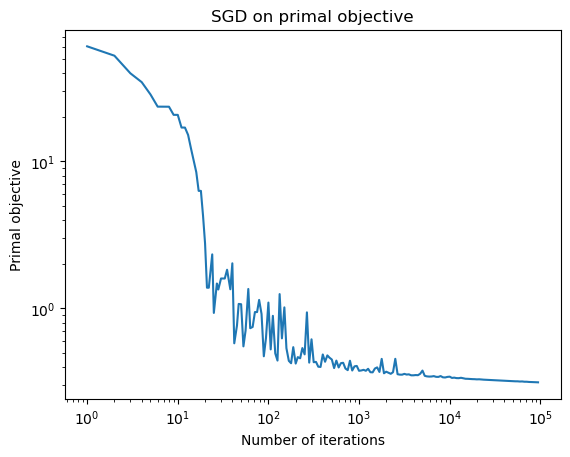

In [16]:
def sgd_for_svm_demo(y, X):
    xs = np.unique(np.round(np.logspace(0, 5, 201)))[:-1]
    max_iter = int(1e5)
    gamma = 1e-4
    lambda_ = 5e1

    num_examples, num_features = X.shape
    w = np.zeros(num_features)
    costs = []
    start = time.time()

    for it in range(max_iter):
        # n = sample one data point uniformly at random data from x
        n = random.randint(0, num_examples - 1)

        grad = calculate_stochastic_gradient(y, X, w, lambda_, n, num_examples)
        w -= gamma / (it + 1) * grad

        cost = calculate_primal_objective(y, X, w, lambda_)

        if it in xs:
            costs += [cost]

    end = time.time()

    print(
        "Final training accuracy = {l} %".format(
            l=np.round(100 * calculate_accuracy(y, X, w), 2)
        )
    )
    print("Training time: " + str(np.round(end - start, 1)) + " seconds ")

    plt.figure()
    plt.title("SGD on primal objective")
    plt.loglog(xs, costs)
    plt.xlabel("Number of iterations")
    plt.ylabel("Primal objective")
    plt.show()


sgd_for_svm_demo(y, X)

## Coordinate Descent (Ascent) for SVM

Compute the closed-form update for the n-th variable alpha, in the dual optimization problem, given alpha and the current corresponding w

In [17]:
def calculate_coordinate_update(y, X, lambda_, alpha, w, n):
    """compute a coordinate update (closed form) for coordinate n.

    Args:
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        X: the dataset matrix, shape = (num_examples, num_features)
        lambda_: positive scalar number
        alpha: vector of dual coordinates, shape = (num_examples)
        w: vector of primal parameters, shape = (num_features)
        n: the coordinate to be updated

    Returns:
        w: updated vector of primal parameters, shape = (num_features)
        alpha: updated vector of dual parameters, shape = (num_examples)

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1., 2., 3.], [4., 5., 6.]])
    >>> w_test = np.array([-0.3, -0.3, -0.3])
    >>> alpha_test = np.array([0.1, 0.1])
    >>> calculate_coordinate_update(y_test, x_test, 1, alpha_test, w_test, 0)
    (array([-0.1,  0.1,  0.3]), array([0.5, 0.1]))
    """
    # calculate the update of coordinate at index=n.
    N = y.size
    x_n, y_n = X[n], y[n]
    old_alpha_n = np.copy(alpha[n])

    gamma = (lambda_*N*(1 - y_n*(x_n@w)))/(x_n@x_n.T)

    gamma_star = np.minimum(np.maximum(gamma, -old_alpha_n), 1 - old_alpha_n)

    alpha[n] = old_alpha_n + gamma_star

    w = w + (1/(lambda_*N))*y_n*gamma*x_n.T
    return w, alpha
    ### END SOLUTION

$Y = diag(y)$

$
\begin{aligned}
f(\alpha + \gamma e_n)  &=  \dfrac{1}{N}\alpha^T \mathbb{1} - \dfrac{1}{N} \gamma e_n^T \mathbb{1} + \dfrac{1}{2 \lambda N^2} (\alpha + \gamma e_n)^TYXX^TY(\alpha + \gamma e_n)\\
                        &= f(\alpha) + \dfrac{1}{N}\gamma - \dfrac{1}{2 \lambda N^2} \lambda N \left( w(\alpha)^T X^TY e_n + e_n^T Y X w(\alpha)\right)\gamma - \dfrac{1}{2 \lambda N^2} e_n^T Y X X^T Y e_n \gamma^2 \\
                        &= f(\alpha) + \dfrac{1}{N}\gamma - \dfrac{1}{N}  e_n^T Y X w(\alpha)\gamma - \dfrac{1}{2 \lambda N^2} y_n^2 e_n^T Y X X^T Y e_n \gamma^2\\
                        &= f(\alpha) + \dfrac{1}{N}\gamma - \dfrac{1}{N} y_n X[n,:] w(\alpha)\gamma - \dfrac{1}{2 \lambda N^2} y_n^2 X[n,:] X[n,:]^T \gamma^2\\
f(\alpha + \gamma e_n)  &= - \dfrac{1}{2 \lambda N^2} X[n,:] X[n,:]^T \gamma^2 + \dfrac{1}{N}(1 - y_n X[n,:] w(\alpha)) \gamma + f(\alpha)
\end{aligned}$

This is a quadratic whose maximum is attained in $\gamma = -\dfrac{b}{2a}$

$\gamma = -\dfrac{\dfrac{1}{N}(1 - y_n X[n,:] w(\alpha))}{-2 \dfrac{1}{2 \lambda N^2} X[n,:] X[n,:]^T}
$

$
\gamma = \dfrac{\lambda N(1 - y_n X[n,:] w(\alpha))}{X[n,:] X[n,:]^T}
$

To satisfy the constraint, we have:

$\gamma^\star = \min\left( \max(\gamma, -\alpha_n), 1 - \alpha_n \right)$

$
\begin{aligned}
w(\alpha + \gamma e_n)  &= w(\alpha) + \dfrac{1}{\lambda N} X^T Y \gamma e_n\\
w(\alpha + \gamma e_n)  &= w(\alpha) +  \dfrac{1}{\lambda N} y_n \gamma X[n,:]^T
\end{aligned}
$

In [18]:
test(calculate_coordinate_update)

✅ Your `calculate_coordinate_update` passed 5 tests.


In [21]:
def calculate_dual_objective(y, X, w, alpha, lambda_):
    """calculate the objective for the dual problem.

    Args:
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        X: the dataset matrix, shape = (num_examples, num_features)
        w: vector of primal parameters, shape = (num_features)
        alpha: vector of dual coordinates, shape = (num_examples)
        lambda_: non negative scalar number

    Output:
        scalar

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1., 2., 3.], [4., 5., 6.]])
    >>> w_test = np.array([-0.3, -0.3, -0.3])
    >>> alpha_test = np.array([0.1, 0.1])
    >>> calculate_dual_objective(y_test, x_test, w_test, alpha_test, 1)
    -0.035
    """
    N = y.size

    ### SOLUTION
    return (1 / N) * np.sum(alpha) - (lambda_ / 2.0) * np.sum(
        w**2
    )

$
\begin{aligned}
OBJ     &= \dfrac{1}{N} \alpha^T \mathbb{1} - \dfrac{1}{2 \lambda N^2} \alpha^T Y X X^T Y \alpha\\
        &= \dfrac{1}{N} \alpha^T \mathbb{1} - \dfrac{1}{2 \lambda N^2} (\lambda N)^2 w(\alpha)^T w(\alpha)\\
OBJ     &= \dfrac{1}{N} \alpha^T \mathbb{1} - \dfrac{\lambda}{2} w(\alpha)^T w(\alpha)
\end{aligned}
$

In [22]:
test(calculate_dual_objective)

✅ Your `calculate_dual_objective` passed 5 tests.


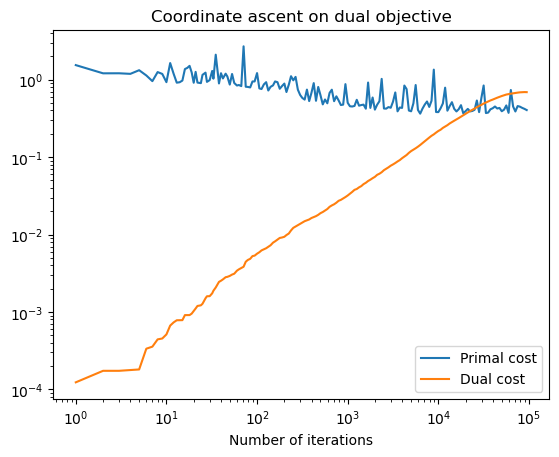

Final training accuracy = 89.1 %
Training time: 1.1 seconds 


In [23]:
# Notice that the gap is going to 0
def coordinate_descent_for_svm_demo(y, X):
    max_iter = int(1e5)
    xs = np.unique(np.round(np.logspace(0, 5, 201)))[:-1]
    lambda_ = 5e1
    p_costs, d_costs = [], []

    num_examples, num_features = X.shape
    w = np.zeros(num_features)
    alpha = np.zeros(num_examples)
    start = time.time()

    for it in range(max_iter):
        # n = sample one data point uniformly at random data from x
        n = random.randint(0, num_examples - 1)

        w, alpha = calculate_coordinate_update(y, X, lambda_, alpha, w, n)

        if it in xs:
            # primal objective
            primal_value = calculate_primal_objective(y, X, w, lambda_)
            # dual objective
            dual_value = calculate_dual_objective(y, X, w, alpha, lambda_)
            # store values
            p_costs += [primal_value]
            d_costs += [dual_value]

    end = time.time()
    plt.figure()
    plt.title("Coordinate ascent on dual objective")
    plt.loglog(xs, p_costs, label="Primal cost")
    plt.loglog(xs, d_costs, label="Dual cost")
    plt.xlabel("Number of iterations")
    plt.legend()
    plt.show()

    print(
        "Final training accuracy = {l} %".format(
            l=np.round(100 * calculate_accuracy(y, X, w), 2)
        )
    )
    print("Training time: " + str(np.round(end - start, 1)) + " seconds ")


coordinate_descent_for_svm_demo(y, X)

#### The gap between the primal cost and the dual cost should go to 0 !

# Theoretical questions

1.  A linear function is both convex and concave because any chord between two points on the
    function's curve overlaps with the curve itself.

2.  A sum of convex functions is also convex becase of the linearity of the sum.

3.  If $f$ and $g$ are differentiable, $(g \circ f)$ is also differentiable and by using the chain 
    rule, we have that 
    $$(g \circ f)''(x) = \left[g'(f(\cdot)) f'(\cdot)\right]'(x) = g''(f(x))(f'(x))^2 + g'(f(x))f''(x)$$
    Because g is increasing, we have that the second derivative of $(g \circ f)$ is positive, so it is convex.